In [1]:
import os
import utility
import torch
import torch.nn as nn
from importlib import import_module
import datetime
import torch.optim as optim
from models import *
import models
from data.datasets import *
from trainers.distiller import Distiller
import losses

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
from torchinfo import summary

In [2]:
class trainArgs:
    gpu_id = 0
    net = 'STMFNet'
    data_dir = 'D:/stmfnet_data'
    out_dir = './train_results'
    load = None
    epochs = 70
    batch_size = 2
    loss = "1*Lap"
    patch_size = 256
    lr = 0.001
    lr_decay = 20
    decay_type = 'step'
    gamma = 0.5
    patience = None
    optimizer = 'ADAMax'
    weight_decay = 0
    featc = [32, 64, 96, 128]
    featnet = 'UMultiScaleResNext'
    featnorm = 'batch'
    kernel_size = 5
    dilation = 1
    finetune_pwc = False
    temp = 10
    alpha = 0.3
    distill_loss_fn = 'KLDivLoss'

args=trainArgs()

In [3]:
from data.datasets import *
from torch.utils.data import DataLoader

torch.cuda.set_device(args.gpu_id)

# training sets
vimeo90k_train = Vimeo90k_quintuplet(
    join(args.data_dir, "vimeo_septuplet"),
    train=True,
    crop_sz=(args.patch_size, args.patch_size),
)
bvidvc_train = BVIDVC_quintuplet(
    join(args.data_dir, "bvidvc"), crop_sz=(args.patch_size, args.patch_size)
)

# validation set
vimeo90k_valid = Vimeo90k_quintuplet(
    join(args.data_dir, "vimeo_septuplet"),
    train=False,
    crop_sz=(args.patch_size, args.patch_size),
    augment_s=False,
    augment_t=False,
)

datasets_train = [bvidvc_train]
train_sampler = Sampler(datasets_train, iter=True)

# data loaders
train_loader = DataLoader(
    dataset=train_sampler, batch_size=args.batch_size, shuffle=True, num_workers=0
)
valid_loader = DataLoader(
    dataset=vimeo90k_valid, batch_size=args.batch_size, num_workers=0
)

In [4]:
# Load the model


torch.cuda.set_device(args.gpu_id)

if not os.path.exists(args.out_dir):
    os.mkdir(args.out_dir)

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# def load_model(filepath):

#     checkpoint = torch.load(filepath)
#     model = STMFNet(args).cuda()
#     model.load_state_dict(checkpoint['state_dict'])
    
#     return model

# model = load_model("./models/stmfnet.pth")

teacher = to_device(STMFNet(args), device)
teacher.to(device)
checkpoint = torch.load('./models/stmfnet.pth')
teacher.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

### define student model

In [6]:
st1 = to_device(student_STMFNet(args), device)
st1.to(device)
checkpoint1 = torch.load('./train_results/checkpoint/model_epoch001.pth')
st1.load_state_dict(checkpoint1['state_dict'])

st2 = to_device(student_STMFNet(args), device)
st2.to(device)
checkpoint2 = torch.load('./train_results/checkpoint/model_epoch005.pth')
st2.load_state_dict(checkpoint2['state_dict'])


<All keys matched successfully>

### distill

In [7]:
def getmax():
    nums = []
    for file in os.listdir('./train_results/checkpoint'):
        if file.endswith('.pth'):
            nums.append(int(file.split('_epoch')[-1].split('.')[0]))
    return max(nums)

getmax()

5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


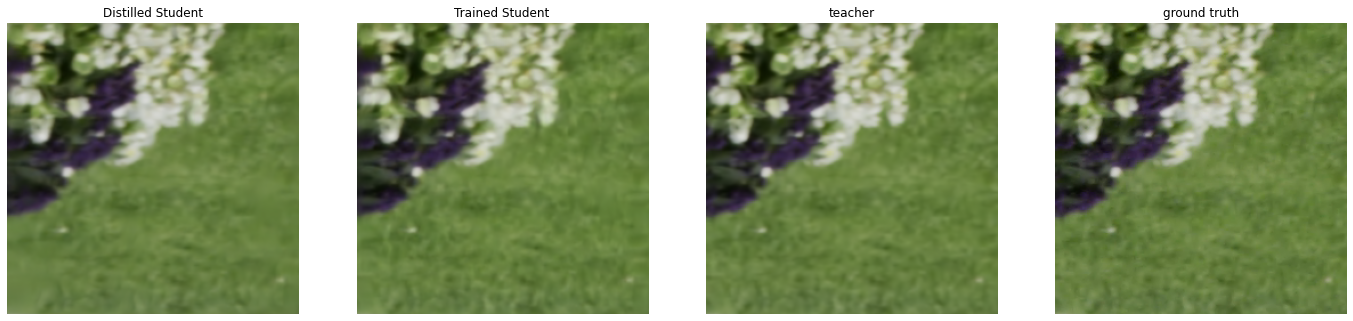

In [17]:
it_1 = next(iter(train_loader))

# for batch_idx, (frame1, frame3, frame4, frame5, frame7) in enumerate(train_loader, 1):
# optimizer.zero_grad()

frame1 = it_1[0].cuda()
frame3 = it_1[1].cuda()
frame4 = it_1[2].cuda()
frame5 = it_1[3].cuda()
frame7 = it_1[4].cuda()

import losses
output1 = st1(frame1, frame3, frame5, frame7)
output2 = st2(frame1, frame3, frame5, frame7)
targets = teacher(frame1, frame3, frame5, frame7)

fig, ax = plt.subplot_mosaic([
    ['student1', 'student2','teacher', 'ground truth'],
], figsize=(24, 10))
fig.patch.set_facecolor('xkcd:white')
ax['student1'].imshow(output1['frame1'][0,:,:,:].permute(1, 2, 0).cpu().detach().numpy())
ax['student1'].set_title('Distilled Student')
ax['student1'].axis('off')

ax['student2'].imshow(output2['frame1'][0,:,:,:].permute(1, 2, 0).cpu().detach().numpy())
ax['student2'].set_title('Trained Student')
ax['student2'].axis('off')

ax['teacher'].imshow(targets['frame1'][0,:,:,:].permute(1, 2, 0).cpu().detach().numpy())
ax['teacher'].set_title('teacher')
ax['teacher'].axis('off')

ax['ground truth'].imshow(frame4[0,:,:,:].permute(1, 2, 0).cpu().detach().numpy())
ax['ground truth'].set_title('ground truth')
ax['ground truth'].axis('off')

plt.show()
torch.cuda.empty_cache()

In [9]:
# from data import testsets

# class testArgs:
#     gpu_id = 0
#     net = 'STMFNet'
#     dataset = 'Ucf101_quintuplet'
#     metrics = ['PSNR', 'SSIM']
#     checkpoint = './train_results/checkpoint/model_epoch008.pth'
#     # checkpoint = './models/stmfnet.pth'
#     data_dir = 'D:/stmfnet_data'
#     out_dir = './tests/results'
#     featc = [64, 128, 256, 512]
#     featnet = 'UMultiScaleResNext'
#     featnorm = 'batch'
#     kernel_size = 5
#     dilation = 1
#     finetune_pwc = False

# args = testArgs()


# densities = {}
# for i in range(getmax()):
#     model = to_device(STMFNet(args), device)
#     model.to(device)
#     model_name = "model_epoch" + str(i+1).zfill(3)
#     model_path = "./train_results/checkpoint/" + model_name + ".pth"
#     checkpoint = torch.load(model_path)
#     model.load_state_dict(checkpoint['state_dict'])

#     weights = [w for name, w in model.named_parameters() if "weight" in name]
#     num_features = sum([w.numel() for w in weights])
#     density = sum([torch.sum(w != 0).item() for w in weights]) / num_features
#     print(density)
#     densities[str(i+1).zfill(3)] = density

#     # test_dir = os.path.join(args.out_dir, args.dataset)
#     # if args.dataset.split("_")[0] in ["VFITex", "Ucf101", "Davis90"]:
#     #     db_folder = args.dataset.split("_")[0].lower()
#     # else:
#     #     db_folder = args.dataset.lower()
#     # test_db = getattr(testsets, args.dataset)(os.path.join(args.data_dir, db_folder))
#     # if not os.path.exists(test_dir):
#     #     os.mkdir(test_dir)

#     # test_db.eval(model, metrics=args.metrics, output_dir=test_dir)

Model Summary

In [10]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = to_device(STMFNet(args), device)
# model.to(device)
# model_path = "./train_results/checkpoint/model_epoch008.pth"
# checkpoint = torch.load(model_path)

# model.load_state_dict(checkpoint['state_dict'])

# x = summary(model, [(2, 3, 256, 256), (2, 3, 256, 256), (2, 3, 256, 256), (2, 3, 256, 256)])

# with open('./summaries/'+model_name+'.txt', 'w') as f:
#     f.write(str(x))
#     f.close()

In [11]:

torch.cuda.empty_cache()

In [12]:
gt = frame4
student_output = st2(frame1, frame3, frame5, frame7)
teacher_output = teacher(frame1, frame3, frame5, frame7)

lap_module = import_module('losses.laplacianpyramid')
charb_module = import_module('losses.charbonnier')

student_loss_function = getattr(lap_module, 'LaplacianLoss')()
distill_loss_function = getattr(lap_module, 'LaplacianLoss')()
distill_loss_function = nn.KLDivLoss(reduction="batchmean")

student_loss_function.to('cuda')
distill_loss_function.to('cuda')

def distillation_loss(student_pred, teacher_pred, distill_loss_fn, temperature=10):
    soft_pred = softmax(student_pred / temperature)
    soft_labels = softmax(teacher_pred / temperature)
    loss = distill_loss_fn(soft_pred, soft_labels) * temperature**2
    return loss

softmax = nn.Softmax(dim=0)

student_loss = student_loss_function(
    gt,
    softmax(student_output['frame1'])
)
print('student_loss: ', student_loss)
distill_loss = distillation_loss(
    student_pred = torch.reshape(student_output['frame1'], (1, -1)),
    teacher_pred = torch.reshape(teacher_output['frame1'], (1, -1)),
    distill_loss_fn = distill_loss_function,
    temperature=10
)
print('distill_loss: ', distill_loss)
effective_loss = 0.1 * student_loss + \
    (1 - 0.1) * distill_loss
print('effective_loss: ', effective_loss)

student_loss:  tensor(27687.0176, device='cuda:0', grad_fn=<AddBackward0>)
distill_loss:  tensor(-39321600., device='cuda:0', grad_fn=<MulBackward0>)
effective_loss:  tensor(-35386672., device='cuda:0', grad_fn=<AddBackward0>)


In [13]:
# import numpy as np
# print('student_loss: ', student_loss)
# distill_loss = distillation_loss(
#     student_pred = np.array([0.25, 0.25, 0.25, 0.25]),
#     teacher_pred = np.array([0.01,0.01,0.01,0.97]),
#     distill_loss_fn = distill_loss_function,
#     temperature=10
# )
# print('distill_loss: ', distill_loss)
# effective_loss = 0.1 * student_loss + \
#     (1 - 0.1) * distill_loss
# print('effective_loss: ', effective_loss)

C:\Users\wg19671\AppData\Local\Temp\ipykernel_15176\3082192376.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  soft_pred = softmax(student_output['frame1'] / temp)
C:\Users\wg19671\AppData\Local\Temp\ipykernel_15176\3082192376.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  soft_labels = softmax(teacher_output['frame1'] / temp)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


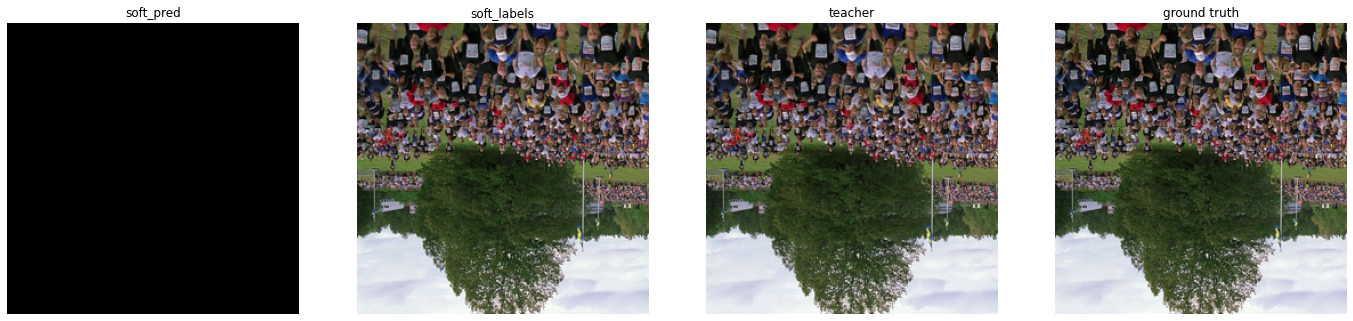

In [15]:
# fig, axs = plt.subplots(10, 2, figsize=(10, 40))
# for t in range(0,20,2):
#     axs[int(t / 2), 0].imshow(softmax(frame4/(t+1))[0,:,:,:].permute(1, 2, 0).cpu().detach().numpy())
#     axs[int(t / 2), 0].set_title("Temperature: " + str(t))

#     axs[int(t / 2), 1].imshow(frame4[0,:,:,:].permute(1, 2, 0).cpu().detach().numpy())
#     axs[int(t / 2), 1].set_title("Temperature: " + str(t))
# plt.show()


softmax = nn.LogSoftmax()
temp = 1

soft_pred = softmax(student_output['frame1'] / temp)
soft_labels = softmax(teacher_output['frame1'] / temp)


fig, ax = plt.subplot_mosaic(
    [
        ['student1', 'student2','teacher', 'ground truth'],
    ],
    figsize=(24, 10)
)
fig.patch.set_facecolor('xkcd:white')
ax['student1'].imshow(soft_pred[0,:,:,:].permute(1, 2, 0).cpu().detach().numpy())
ax['student1'].set_title('soft_pred')
ax['student1'].axis('off')

ax['student2'].imshow(soft_labels[0,:,:,:].permute(1, 2, 0).cpu().detach().numpy())
ax['student2'].set_title('soft_labels')
ax['student2'].axis('off')

ax['teacher'].imshow(teacher_output['frame1'][0,:,:,:].permute(1, 2, 0).cpu().detach().numpy())
ax['teacher'].set_title('teacher')
ax['teacher'].axis('off')

ax['ground truth'].imshow(frame4[0,:,:,:].permute(1, 2, 0).cpu().detach().numpy())
ax['ground truth'].set_title('ground truth')
ax['ground truth'].axis('off')

plt.show()
torch.cuda.empty_cache()
del soft_pred
del soft_labels